<a href="https://colab.research.google.com/github/minjeong-kim-git/HUFS-RL-2022/blob/main/Day%2003/2021_05_12_REINFORCE_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCE on CartPole-v0

> In this post, We will take a hands-on-lab of Monte Carlo Policy Gradient (also known as REINFORCE) on openAI gym CartPole-v0 environment. This is the coding exercise from udacity Deep Reinforcement Learning Nanodegree.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Reinforcement_Learning, PyTorch, Udacity]
- image: images/CartPole-v0.gif

## REINFORCE
---
In this notebook, you will implement REINFORCE agent on OpenAI Gym's CartPole-v0 environment. For summary, The **REINFORCE** algorithm ([Williams, 1992](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf)) is a monte carlo variation of policy gradient algorithm in RL. The agent collects the trajectory of an episode from current policy. Usually, this policy depends on the policy parameter which denoted as $\theta$. Actually, REINFORCE is acronym for "**RE**ward **I**ncrement = **N**onnegative **F**actor * **O**ffset **R**einforcement * **C**haracteristic **E**ligibility"

### Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the Environment and Agent

CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space. 

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


### Define Policy
Unlike value-based method, the output of policy-based method is the probability of each action. It can be represented as policy. So activation function of output layer will be softmax, not ReLU.

In [4]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

### REINFORCE

In [5]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # Calculate the loss 
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

### Run

In [6]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)

Episode 100	Average Score: 20.22
Episode 200	Average Score: 41.21
Episode 300	Average Score: 85.37
Episode 400	Average Score: 91.89
Episode 500	Average Score: 143.20
Episode 600	Average Score: 125.37
Episode 700	Average Score: 122.81
Episode 800	Average Score: 103.71
Episode 900	Average Score: 160.88
Episode 1000	Average Score: 126.33
Episode 1100	Average Score: 111.43
Environment solved in 1070 episodes!	Average Score: 195.44


### Plot the learning progress

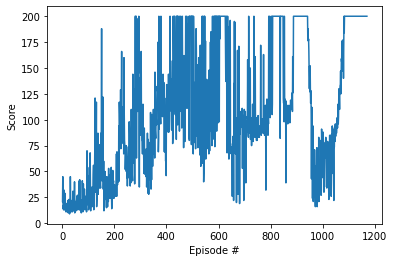

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [8]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(1000):
        vid.capture_frame()
        action, _ = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [9]:
show_video_of_model(policy, 'CartPole-v0')

FileNotFoundError: ignored

In [ ]:
show_video('CartPole-v0')